### VGG19-based Autoencoder

Here, we developed on VGG19 based autoencoder, where the output of encoder is the 'block4conv4' layer of VGG19. This was chosen after several experiments, since extracting output from this specific layer gave the best results.

Once the autoencoder is trained, its encoder is used to extract image embeddings for each chest x-ray image. Each image embedding is of shape 28x28x512

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-11-14 18:57:43.416265: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 18:57:43.736334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Specify dataset directory and image dimensions
data_dir = 'NLMCXR_png'
image_dim = (224, 224,3)  # VGG19 accepts this dimension as input

In [3]:
import os
from sklearn.model_selection import train_test_split

# Get a list of image files in the directory
image_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith(".png")]

# Create a DataFrame with the image file paths
df = pd.DataFrame({'filename': image_files})

df['label'] = 0  

# First split: 90% for the combined training + validation, 10% for the test
X_temp, test_data = train_test_split(df, test_size=0.1, random_state=42)

# Second split: Split the 90% into 70% train and 20% validation
train_data, val_data = train_test_split(X_temp, test_size=2/9, random_state=42)

In [4]:
# Initialize data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Create flow generators for training and testing sets
train_generator = train_datagen.flow_from_dataframe(train_data,
                                                     x_col='filename',
                                                     y_col='label',
                                                     target_size=image_dim[:2],
                                                     batch_size=16,
                                                     class_mode=None,  # 'raw' means no labels
                                                     color_mode='rgb')


Found 5229 validated image filenames.


In [6]:
valid_generator = test_datagen.flow_from_dataframe(val_data,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=image_dim[:2],
                                                    batch_size=16,
                                                    class_mode=None,  # 'raw' means no labels
                                                    color_mode='rgb')


Found 1494 validated image filenames.


In [7]:
test_generator = test_datagen.flow_from_dataframe(test_data,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=image_dim[:2],
                                                    batch_size=16,
                                                    class_mode=None,  # 'raw' means no labels
                                                    color_mode='rgb')


Found 747 validated image filenames.


In [8]:
from tensorflow.keras.utils import Sequence

class AutoencoderImageDataGenerator(Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        batch_x = self.generator[index]
        return batch_x, batch_x  # Return the same image as both input and target


In [9]:
# Wrap your generators with AutoencoderImageDataGenerator
train_autoencoder_generator = AutoencoderImageDataGenerator(train_generator)
valid_autoencoder_generator = AutoencoderImageDataGenerator(valid_generator)


In [10]:
test_autoencoder_generator = AutoencoderImageDataGenerator(test_generator)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19

# Load VGG19 model pretrained on imagenet data
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set up the encoder
encoder_layer = 'block4_conv4'
encoder_output = base_model.get_layer(encoder_layer).output
encoder = models.Model(inputs=base_model.input, outputs=encoder_output)

# Set up the decoder
decoder_input = layers.Input(shape=encoder.output_shape[1:])
x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = models.Model(inputs=decoder_input, outputs=x)

# Set up the autoencoder
autoencoder_input = layers.Input(shape=(224, 224, 3))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = models.Model(inputs=autoencoder_input, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


2023-11-14 17:44:47.399483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:44:47.581197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:44:47.581258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:44:47.588958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:44:47.589020: I tensorflow/compile

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 28, 28, 512)       10585152  
                                                                 
 model_1 (Functional)        (None, 224, 224, 3)       1550467   
                                                                 
Total params: 12135619 (46.29 MB)
Trainable params: 12135619 (46.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for improvement (validation loss)
    patience=5,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

In [14]:
epochs = 30

In [15]:
model = autoencoder.fit(
    train_autoencoder_generator,
    epochs=epochs,
    validation_data=valid_autoencoder_generator,
    callbacks=[early_stopping],
    verbose=1  # Set the verbosity level as needed
)


Epoch 1/30


2023-11-14 17:45:20.042978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-14 17:45:21.804736: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 17:45:23.512604: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa4484fc5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 17:45:23.512652: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-11-14 17:45:23.554334: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 17:45:23.838602: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 17:45:23.920954: I ./tensorflow/compiler/jit/devi

KeyboardInterrupt: 

In [18]:
autoencoder.save('autoencoder_block4_conv4.h5')

In [27]:
loss = autoencoder.evaluate(test_autoencoder_generator)

47/47 [==============================] - 7s 135ms/step - loss: 4.7700e-04


In [28]:
loss

0.00047699667629785836

In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def extract_features(directory):
    features = []
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            # Load and preprocess the image
            image_path = os.path.join(directory, filename)
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)

            # Extract features
            feature = model.predict(image, use_multiprocessing=True)
            features.append(feature.flatten())

    return np.array(features)

# Extract features from augmented images
augmented_images_dir = 'augmented_train_images'
augmented_image_features = extract_features(augmented_images_dir)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5cc3772e0>

In [16]:
# Load and preprocess the images as NumPy arrays
def load_and_preprocess_image(filename):
    img = load_img(filename, target_size=image_dim[:2])
    img = img_to_array(img)
    
    img /= 255.0  # Rescale pixel values to [0, 1]
    return img

In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

train_images = np.array([load_and_preprocess_image(filename) for filename in df['filename']])


In [34]:
train_images.shape

(7470, 224, 224, 3)

In [35]:
image_embeddings = encoder.predict(train_images)

234/234 [==============================] - 8s 30ms/step


In [37]:
np.save('imgEmbeddingsB4C4.npy', image_embeddings)

In [ ]:
# After training the autoencoder
trained_encoder = encoder

In [ ]:
# Get the encoder sub-model from the autoencoder
encoder_sub_model = autoencoder.get_layer('model')  
encoder_output_layer = 'block4_conv4'
# Create a new model that mimics the architecture of the encoder and copies the trained weights
encoder_trained = Model(inputs=encoder_sub_model.input, outputs=encoder_sub_model.get_layer(encoder_output_layer).output)


In [ ]:
encoder_data = encoder_trained.predict(train_images)

In [ ]:
np.save('image_embeddings.npy',encoder_data)

In [ ]:
from tensorflow.keras.models import load_model

image_encoder = load_model('encoder_model.h5')

In [ ]:
image_encoder.compile(optimizer='adam', loss = 'categorical_crossentropy')
image_encoder.summary()

In [ ]:
train_images.shape

In [ ]:
image_features = image_encoder.predict(train_images)

In [ ]:
image_features.shape

In [ ]:
np.save('image_features.npy', image_features)

In [ ]:
encoder.save('encoder_model.h5')

In [ ]:
autoencoder.save('autoencoder_model.h5')

In [ ]:
import matplotlib.pyplot as plt


In [29]:
train_loss = model.history['loss']
val_loss = model.history['val_loss']


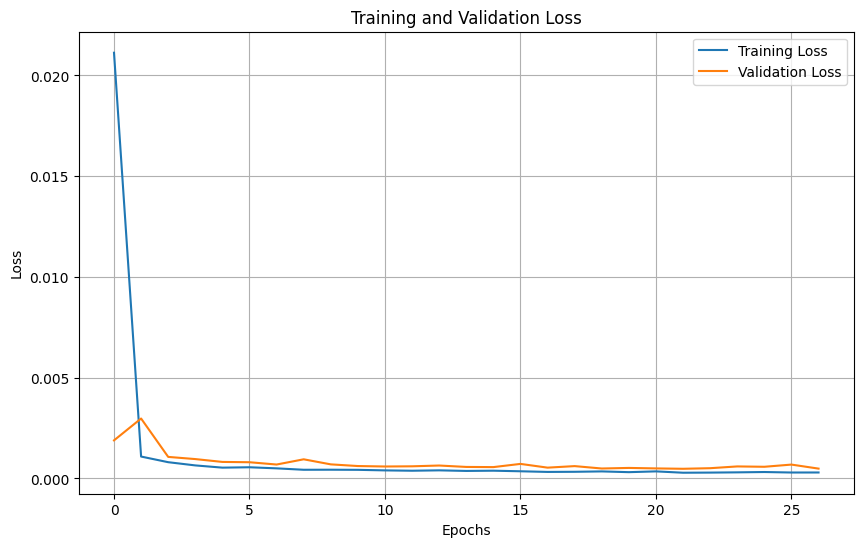

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
